# Importing Libraries

In [1]:
pip install tensorflow 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import warnings as wg
wg.filterwarnings("ignore") 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

# Loading the Data

In [3]:
text = open("1661-0.txt", encoding='utf8').read().lower()
print('corpus length:',len(text))

corpus length: 581888


# Data Preprocessing

In [4]:
character = sorted(list(set(text)))
char_indices = dict((c,i) for i,c in enumerate(character))
indices_char = dict((i,c) for i, c in enumerate(character))

print(f'unique chars: {len(character)}')

unique chars: 73


In [5]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - seq_len, step):
    sentences.append(text[i: i +seq_len])
    next_chars.append(text[i + seq_len])
print(f'num training examples: {len(sentences)}')    

num training examples: 193950


In [6]:
x = np.zeros((len(sentences), seq_len, len(character)), dtype=np.bool)
y = np.zeros((len(sentences), len(character)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]
    
    

'e'

In [7]:
x[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [8]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [9]:
x.shape

(193950, 40, 73)

In [10]:
y.shape

(193950, 73)

# Creating the Model

In [11]:
model = Sequential()
model.add(LSTM(500, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

# Model Summary

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1148000   
                                                                 
 dense (Dense)               (None, 73)                36573     
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 1,184,573
Trainable params: 1,184,573
Non-trainable params: 0
_________________________________________________________________


# Training our model

In [13]:
# Training our model
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=10, 
                    shuffle=True).history

Epoch 1/10
1501/1501 [==============================] - 614s 406ms/step - loss: 2.1315 - accuracy: 0.3911 - val_loss: 2.1664 - val_accuracy: 0.4124
Epoch 2/10
1501/1501 [==============================] - 581s 387ms/step - loss: 1.5303 - accuracy: 0.5413 - val_loss: 1.9250 - val_accuracy: 0.4758
Epoch 3/10
1501/1501 [==============================] - 601s 400ms/step - loss: 1.4036 - accuracy: 0.5726 - val_loss: 1.9181 - val_accuracy: 0.4979
Epoch 4/10
1501/1501 [==============================] - 592s 394ms/step - loss: 1.3335 - accuracy: 0.5914 - val_loss: 2.0671 - val_accuracy: 0.4742
Epoch 5/10
1501/1501 [==============================] - 615s 410ms/step - loss: 1.4139 - accuracy: 0.6036 - val_loss: 4.0039 - val_accuracy: 0.3485
Epoch 6/10
1501/1501 [==============================] - 628s 418ms/step - loss: 2.5322 - accuracy: 0.4166 - val_loss: 3.6321 - val_accuracy: 0.2108
Epoch 7/10
1501/1501 [==============================] - 631s 420ms/step - loss: 3.3318 - accuracy: 0.2164 - val_

# Saving our Model

In [28]:
model.save('network.h5')
pickle.dump(history, open("history.p", "wb"))

# Loading our Model

In [29]:
model = load_model('network.h5')
history = pickle.load(open("history.p", "rb"))

# Model Evaluation

In [30]:
loss_and_acc=model.evaluate(x,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 521s 86ms/step - loss: 3.5679 - accuracy: 0.1758
Test Loss 3.5678508281707764
Test Accuracy 0.17577725648880005


# Plotting Training and Validation Plots

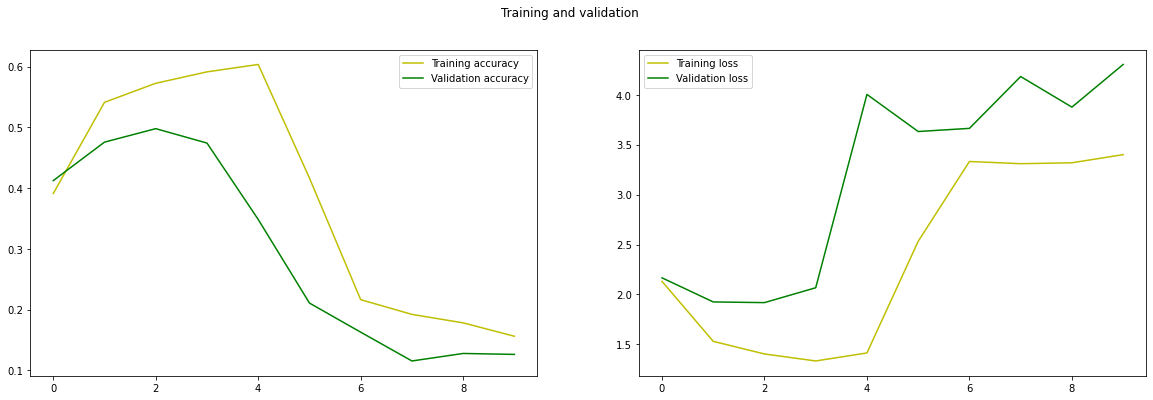

In [31]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [32]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

# Functions to get next probable characters

In [33]:
#functions to get next probable characters
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [34]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [35]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]


# Prediction

In [36]:
#Prediction
quotes = [   
    "It is not a lack of  love, but a  lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN)is a type of artificial neural network which uses sequential data or time series data.",
    "Machine learning is the science of getting computers to act without being explicitly programmed.",
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "The goal of AI is to  make a  compter like humans to solve complex problems.",
    "Statistics are defined as numerical data, and is the field of math that deals with the collection, tabulation and interpretation of numerical data."
    ]

In [25]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()


it is not a lack of  love, but a  lack o
['  ', 'e ', 'd ', 'a ', 'r ']

recurrent neural network (rnn)is a type 
['  ', 'a ', 'p ', 't ', 'u ']

machine learning is the science of getti
[' a ', '.a ', 'de ', 'ea ', 'tae ']

deep learning is subset of machine learn
[' x ', 'd ', 'a ', 'e ', '. ']

the goal of ai is to  make a  compter li
['  ', 'd ', 'e ', 'a ', 'n ']

statistics are defined as numerical data
[' aa ', 'd ', 'e ', 'r ', '. ']

